<a href="https://colab.research.google.com/github/tripuragorla/CMPE-297-Assignments/blob/main/Assignment%203/HuggingFaces_TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: shivkumarganesh (use `wandb login --relogin` to force relogin)


In [ ]:
import wandb

wandb.init(project="Hugging-Faces Text Classification", entity="shivkumarganesh")

wandb: Currently logged in as: shivkumarganesh (use `wandb login --relogin` to force relogin)


In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset('imdb')

checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Inspecting the Data Structure IMDB
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
def tokenizer_function(example):
  return tokenizer(example['text'], truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenizer_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-f209d41e0953ea9d.arrow


  0%|          | 0/25 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-83370364db5a4437.arrow


In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(250))
small_unsupervised_dataset = tokenized_datasets["unsupervised"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]
full_unsupervised_dataset = tokenized_datasets["unsupervised"]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-dfb0e7b37c23604b.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-409699cecc7b4320.arrow


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
from datasets import load_metric
import numpy as np

def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", report_to='wandb')

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset = small_train_dataset,
    eval_dataset = small_eval_dataset,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 5000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1875
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.375900,0.327236,0.900000,0.903475
2,0.187000,0.596282,0.892000,0.903226
3,0.099100,0.614638,0.884000,0.889734


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 250
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set  don't have a correspondi

TrainOutput(global_step=1875, training_loss=0.1832265884399414, metrics={'train_runtime': 431.8292, 'train_samples_per_second': 34.736, 'train_steps_per_second': 4.342, 'total_flos': 1865099577014400.0, 'train_loss': 0.1832265884399414, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 250
  Batch size = 8


{'epoch': 3.0,
 'eval_accuracy': 0.884,
 'eval_f1': 0.8897338403041826,
 'eval_loss': 0.6146382093429565,
 'eval_runtime': 2.6859,
 'eval_samples_per_second': 93.08,
 'eval_steps_per_second': 11.914}

In [ ]:
wandb.finish()

eval/accuracy,█▅▁▁
eval/f1,██▁▁
eval/loss,▁███
eval/runtime,▇▁█▂
eval/samples_per_second,▂█▁▇
eval/steps_per_second,▂█▁▇
train/epoch,▁▂▄▅▆███
train/global_step,▁▂▄▅▆███
train/learning_rate,█▄▁
train/loss,█▃▁
train/total_flos,▁


In [ ]:
!pip install gradio

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification')

Configuration saved in /content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/config.json
Model weights saved in /content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification')

tokenizer config file saved in /content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/special_tokens_map.json


('/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/tokenizer_config.json',
 '/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/special_tokens_map.json',
 '/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/vocab.txt',
 '/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/added_tokens.json',
 '/content/drive/MyDrive/Semester 4/Advance Deep Learning/Assignments/Assignment 4/Models/imdb_classification/tokenizer.json')

In [ ]:
trainer.predict([tokenizer('Hello World')])

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


PredictionOutput(predictions=array([[-3.623625 ,  3.8763165]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.0144, 'test_samples_per_second': 69.324, 'test_steps_per_second': 69.324})

In [ ]:
import gradio as gr

def process_sentences(sentence):
  pred_outputs = trainer.predict([tokenizer(sentence)])
  output = np.argmax(pred_outputs.predictions)
  if output == 0:
    return 'Sentence is Negative'
  else:
    return 'Sentence is Positive'

gr.Interface(fn=process_sentences, inputs=["text"], outputs="text").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://31627.gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://31627.gradio.app')

# Gradio Output
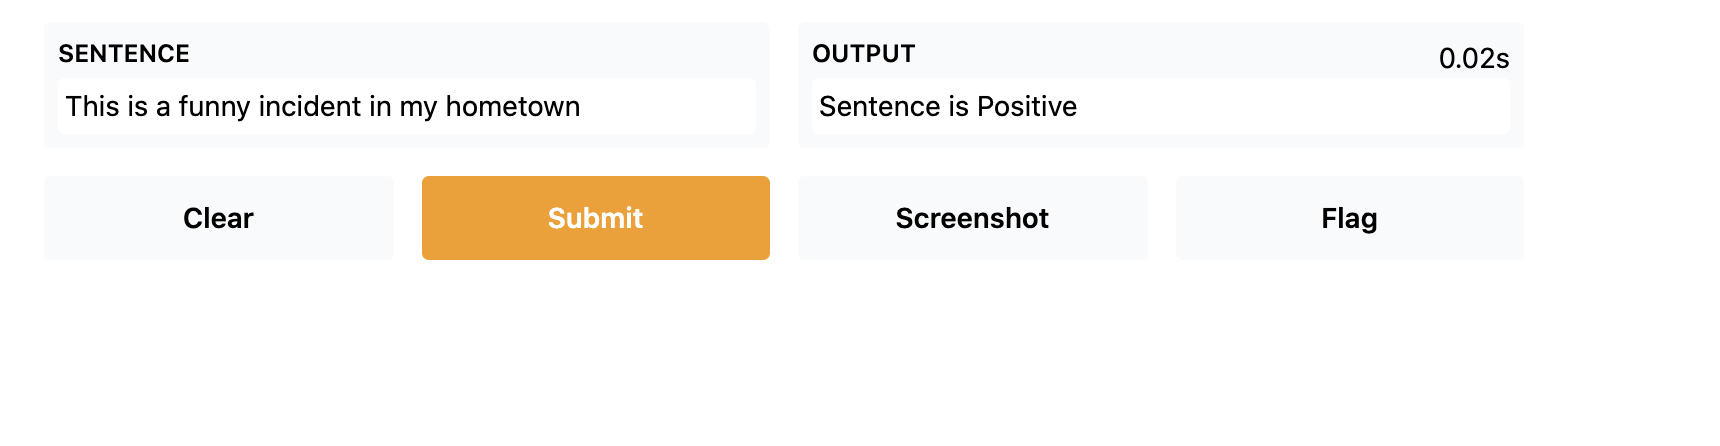

# Wandb Train Outputs
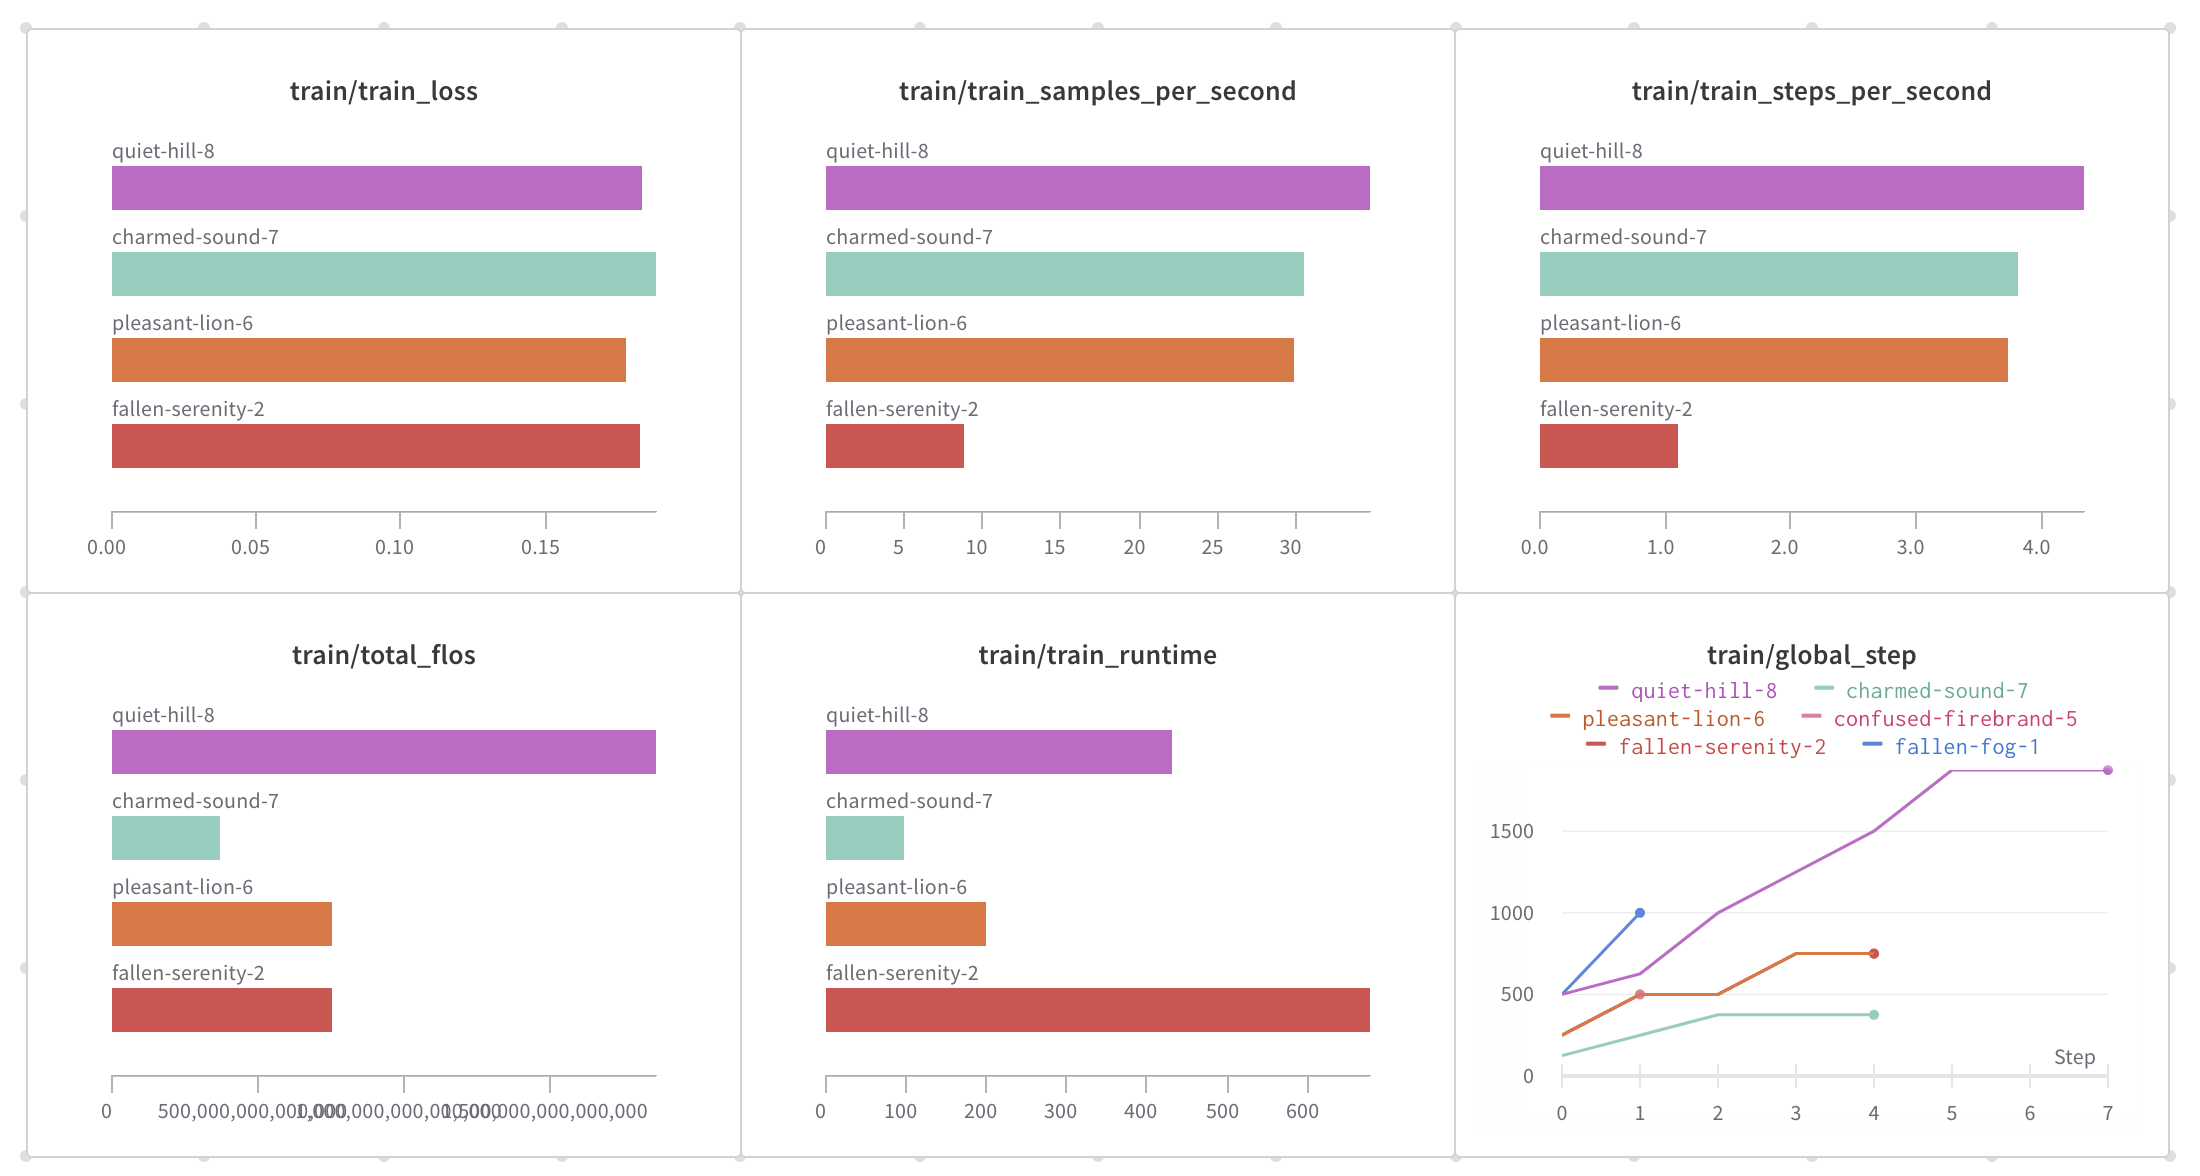

#Wandb Eval Outputs
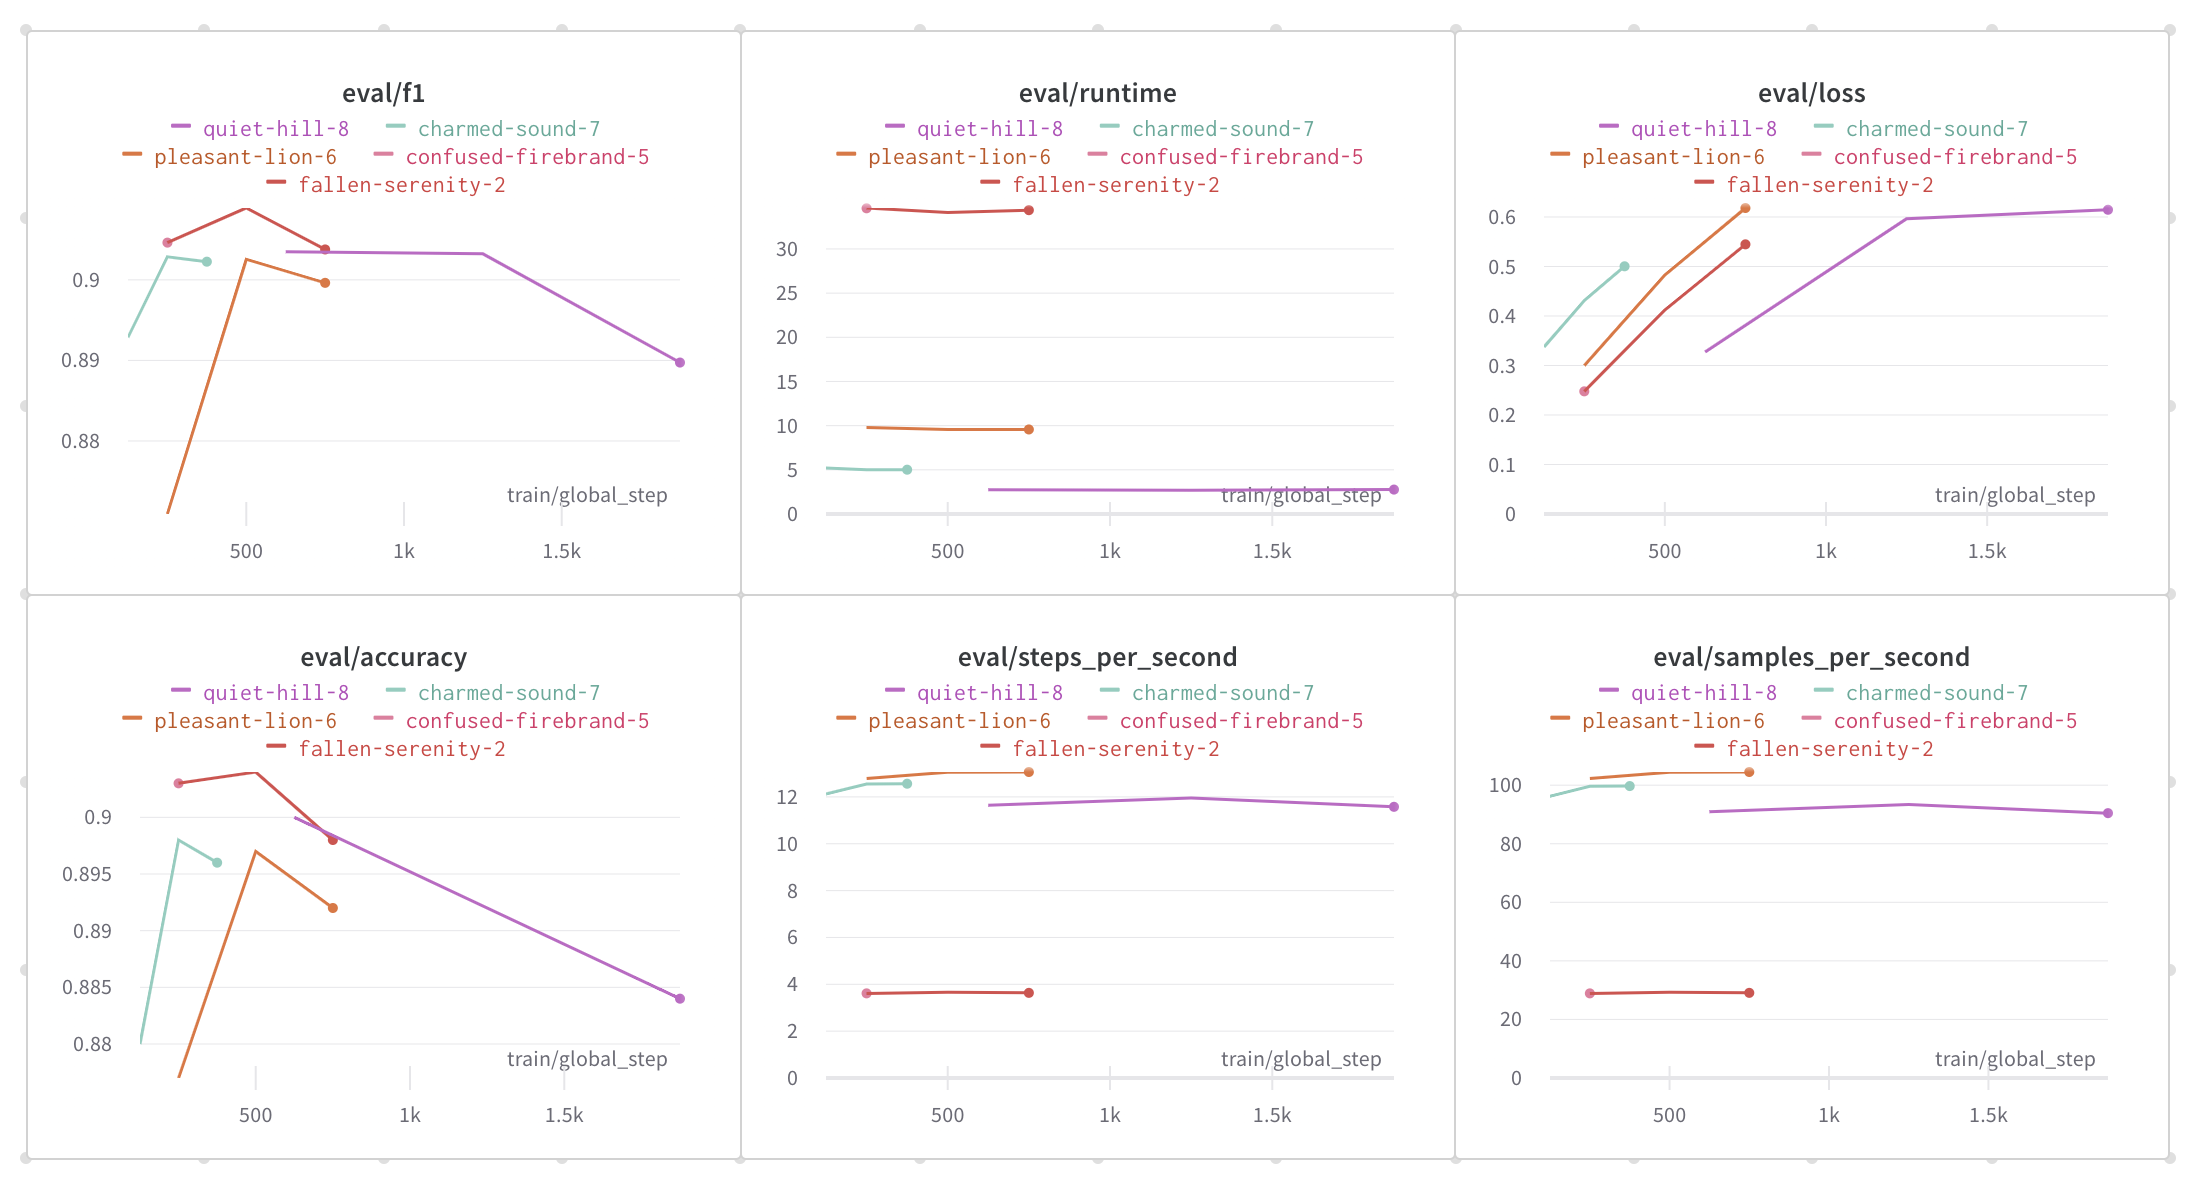